In [ ]:
#default_exp data.core

In [ ]:
#export
from fastai_local.imports import *
from fastai_local.test import *
from fastai_local.core import *
from fastai_local.data.pipeline import *
from fastai_local.data.source import *
from fastai.datasets import *

# Helper functions for processing data

> Functions for getting, splitting, and labeling data, etc

## Get, split, and label

For most data source creation we need functions to get a list of items, split them in to train/valid sets, and label them. fastai provides functions to make each of these steps easy (especially when combined with `fastai.data.blocks`).

### Get

First we'll look at functions that *get* a list of items (generally file names).

We'll use *tiny MNIST* (a subset of MNIST with just two classes, `7`s and `3`s) for our examples/tests throughout this page.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/7'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/3')]

In [ ]:
# export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
# export
def get_files(path, extensions=None, recurse=False, include=None):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`."
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return res

This is the most general way to grab a bunch of file names from disk. If you pass `extensions` (including the `.`) then returned file names are filtered by that list. Only those files directly in `path` are included, unless you pass `recurse`, in which case all child folders are also searched recursively. `include` is an optional list of directories to limit the search to.

In [ ]:
t3 = get_files(path/'train'/'3', extensions='.png')
t7 = get_files(path/'train'/'7', extensions='.png')
t  = get_files(path/'train', extensions='.png', recurse=True)
test_eq(len(t), len(t3)+len(t7))
test_eq(len(get_files(path/'train'/'3', extensions='.jpg')),0)
test_eq(len(t), len(get_files(path, extensions='.png', recurse=True, include='train')))
coll_repr(t)

'(709 items) [/home/ubuntu/.fastai/data/mnist_tiny/train/7/7010.png,/home/ubuntu/.fastai/data/mnist_tiny/train/7/79.png,/home/ubuntu/.fastai/data/mnist_tiny/train/7/9022.png,/home/ubuntu/.fastai/data/mnist_tiny/train/7/7284.png,/home/ubuntu/.fastai/data/mnist_tiny/train/7/7085.png,/home/ubuntu/.fastai/data/mnist_tiny/train/7/7547.png,/home/ubuntu/.fastai/data/mnist_tiny/train/7/8698.png,/home/ubuntu/.fastai/data/mnist_tiny/train/7/8463.png,/home/ubuntu/.fastai/data/mnist_tiny/train/7/7525.png,/home/ubuntu/.fastai/data/mnist_tiny/train/7/8345.png...]'

In [ ]:
#hide
test_eq(len(get_files(path/'train'/'3')),346)
test_eq(len(get_files(path, extensions='.png', recurse=True, include=['train', 'test'])),729)

In [ ]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
#export
def get_image_files(path, include=None, **kwargs):
    "Get image files in `path` recursively."
    return get_files(path, extensions=image_extensions, recurse=True, include=include)

This is simply `get_files` called with a list of standard image extensions.

In [ ]:
test_eq(len(t), len(get_image_files(path, recurse=True, include='train')))

In [ ]:
#export
def image_getter(suf='', **kwargs):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`"
    def _inner(o, **kw): return get_image_files(o/suf, **{**kwargs,**kw})
    return _inner

It's often useful to be able to create functions with customized behavior. `fastai.data` generally uses functions named as verbs ending in `er` things that create these functions. `image_getter` is a simple example of such a function creator.

In [ ]:
t = get_files(path/'train', extensions='.png', recurse=True, include='3')
f = image_getter('train',  extensions='.png', recurse=True, include='3')
test_eq(len(t), len(f(path)))

### Split

The next set of functions are used to *split* data into training and validation sets. The functions return two lists - a list of indices or masks for each of training and validation sets.

In [ ]:
# export
def random_splitter(valid_pct=0.2, seed=None, **kwargs):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o, **kwargs):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = torch.randperm(len(o))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [ ]:
src = list(range(30))
f = random_splitter(seed=42)
trn,val = f(src)
assert 0<len(trn)<len(src)
assert all(o not in val for o in trn)
test_eq(len(trn), len(src)-len(val))
# test random seed consistency
test_eq(f(src)[0], trn)
trn,val

(tensor([10, 18, 16, 23, 28, 26, 20,  7, 21, 22, 29, 13, 14,  2,  4,  1,  9, 11,
         17, 19, 27,  5, 24,  3]), tensor([12,  0,  6, 25,  8, 15]))

In [ ]:
# export
def _grandparent_idxs(items, name): return mask2idxs(Path(o).parent.parent.name == name for o in items)

In [ ]:
# export
def grandparent_splitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _grandparent_idxs(o, train_name),_grandparent_idxs(o, valid_name)
    return _inner

In [ ]:
items = [path/'train/3/9932.png', path/'valid/7/7189.png', 
         path/'valid/7/7320.png', path/'train/7/9833.png',  
         path/'train/3/7666.png', path/'valid/3/925.png',
         path/'train/7/724.png', path/'valid/3/93055.png']
f = grandparent_splitter()
test_eq(f(items),[[0,3,4,6],[1,2,5,7]])

### Label

The final set of functions is used to *label* a single item of data.

In [ ]:
# export
def parent_label(o, **kwargs):
    "Label `item` with the parent folder name."
    return o.parent.name if isinstance(o, Path) else o.split(os.path.sep)[-1]

Note that `parent_label` doesn't have anything customize, so it doesn't return a function - you can just use it directly.

In [ ]:
test_eq(parent_label(items[0]), '3')
[parent_label(o) for o in items]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
# export
def re_labeller(pat):
    "Label `item` with regex `pat`."
    pat = re.compile(pat)
    def _inner(o, **kwargs):
        res = pat.search(str(o))
        assert res,f'Failed to find "{pat}" in "{o}"'
        return res.group(1)
    return _inner

`re_labeller` is a very flexible function since it handles any regex search of the stringified item. For instance, here's an example the replicates the previous `parent_label` results.

In [ ]:
f = re_labeller(r'/(\d)/')
test_eq(parent_label(items[0]), '3')
[f(o) for o in items]

['3', '7', '7', '7', '3', '3', '7', '3']

## Convenience functions

In [ ]:
#export
def show_image(im, ax=None, figsize=None, title=None, **kwargs):
    "Show a PIL image on `ax`."
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    if isinstance(im,Tensor) and im.shape[0]<5: im=im.permute(1,2,0)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

In [ ]:
fn = t[0]; fn

PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/3/983.png')

TypeError: Image data cannot be converted to float

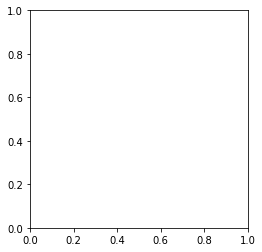

In [ ]:
ax = show_image(fn)

In [ ]:
#export
def show_title(o, ax=None):
    if ax is None: print(o)
    else: ax.set_title(o)